In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import copy

import torch
import torch.nn as nn
from torch.distributions import constraints, transform_to
import torch.optim as optim
import torch.autograd as autograd

import pyro
import pyro.distributions as dist
import pyro.contrib.gp as gp
from pyro.nn import PyroSample, PyroModule
from pyro.infer import autoguide, SVI, Trace_ELBO

In [2]:
print(torch.__version__)
print(pyro.__version__)

1.3.0.post2
1.0.0


# Helper functions

In [3]:
def set_random_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        
def plot_obj(obj_function):

    steps = 100
    strides = 200

    X1 = torch.linspace(const_x1_min, const_x1_max, steps)
    X2 = torch.linspace(const_x2_min, const_x2_max, steps)

    X1_mesh, X2_mesh = torch.meshgrid(X1, X2)
    
    Z_mesh = obj_function(torch.stack((X1_mesh.flatten(), X2_mesh.flatten()), dim=1)).reshape(steps, steps)
    plt.contourf(
        X1_mesh.detach().numpy(), 
        X2_mesh.detach().numpy(), 
        Z_mesh.detach().numpy(), strides)
    
    plt.colorbar()

normal_phi = lambda x: torch.exp(-x.pow(2)/2)/np.sqrt(2*np.pi)
normal_Phi = lambda x: (1 + torch.erf(x / np.sqrt(2))) / 2

def find_best_solution(xmins, target_lms):
    closest_dist = np.inf
    closest_point = None
    
    for xmin in xmins:
        for bh_lm in target_lms:
            dist = np.linalg.norm(xmin-bh_lm)
            if dist < closest_dist: 
                closest_dist = dist
                closest_point = xmin
                
    return closest_point, closest_dist

# Target function

In [4]:
const_x1_min = -5
const_x1_max = 10

const_x2_min = 0
const_x2_max = 15

# Creating constraints
constr = [
    constraints.interval(const_x1_min, const_x1_max),
    constraints.interval(const_x2_min, const_x2_max)
]

def branin_hoo(x):
    """ Compute Branin-Hoo function for fixed constants """
    a = 1.0
    b = 5.1 / (4 * np.pi**2)
    c = 5.0 / np.pi
    r = 6.0
    s = 10.0
    t = 1.0 / (8 * np.pi)
    x1 = x[...,0]
    x2 = x[...,1]
    return a * (x2 - b*x1**2 + c*x1 - r)**2 + s*(1 - t)*torch.cos(x1) + s

# Checking LMs
branin_hoo_lms_np = np.stack(
    (np.array([-math.pi, math.pi, 9.42478]), 
     np.array([12.275, 2.275, 2.475])), axis=1)

branin_hoo_lms = torch.stack(
    (torch.tensor([-math.pi, math.pi, 9.42478]), 
     torch.tensor([12.275, 2.275, 2.475])), dim=1)

assert np.allclose(branin_hoo(branin_hoo_lms).numpy(),
        np.array([0.397887, 0.397887, 0.397887], dtype=np.float32), rtol=1e-6)

# SBO approach

In [5]:
def train(model, num_steps=1000, adam_params={"lr":0.1}):
    """ Trains the semi-parametric model. """
        
    # Autoguide
    guide = autoguide.AutoMultivariateNormal(model.model)

    # Optimizer
    optimizer = pyro.optim.Adam(adam_params)
    loss = Trace_ELBO()
    svi = SVI(model.model, guide, optimizer, loss)
    
    # do gradient steps
    losses = []
    for _ in range(num_steps):
        losses.append(svi.step())
    
    return losses, guide

In [6]:
def find_a_candidate(model_predict, x_init, constr, num_steps=1000, lr=0.1, num_samples=5):
    """ Finds new candidate """
    
    def transf_values(values, constr, dims, inv_mode=False):
        """ Transforming (un)constrained variables to (un)constrained domain """
        
        x_tmp = ()
        for i in range(dims):
            if inv_mode:
                x_tmp += (transform_to(constr[i]).inv(values[:, i]), )
            else:
                x_tmp += (transform_to(constr[i])(values[:, i]), )
            
        x = torch.stack(x_tmp, dim=1)
        return x
            
    x_dims = x_init.shape[-1]
    
    x_uncon_init = transf_values(x_init, constr, x_dims, inv_mode=True)
    x_uncon = x_uncon_init.clone().detach().requires_grad_(True)
    
    # TODO: at the moment we are using torch optimizer, should we change to pyro?
    #     unconstrained minimiser 
    minimizer = optim.Adam([x_uncon], lr=lr)
    
    def closure():
        minimizer.zero_grad()
        x = transf_values(x_uncon, constr, x_dims)
        
        y = model_predict(x)['EI'].mean(0)
        
        autograd.backward(x_uncon, autograd.grad(y, x_uncon))      
        return y
    
    for _ in range(num_steps):
        minimizer.step(closure)
   
    x = transf_values(x_uncon, constr, x_dims)
    
    return x.detach()

In [7]:
def next_x(model_predict, constr, num_candidates=5, num_steps=1000, lr=0.1, num_samples=5):
    """ Finds the next best candidate on the acquisition function surface """
    
    candidates = []
    values = []
    
    # start with the last step
    x_init = model_predict.model.X[-1:]
    for i in range(num_candidates):

        x_can = find_a_candidate(model_predict, x_init, constr, 
                             num_steps=num_steps, lr=lr, num_samples=num_samples)
        
        y = model_predict(x_can)['EI'].mean(0)
        
        candidates.append(x_can)
        values.append(y)
        
        # a new random attempt initial point
        for _ in range(100):
            x_init = torch.stack((
                    x_can[:,0].new_empty(1).uniform_(const_x1_min, const_x1_max),
                    x_can[:,1].new_empty(1).uniform_(const_x2_min, const_x2_max)), dim=1)

            y_init = model_predict(x_init)['EI'].mean(0)
            if y_init < 0.0:
                break  
        
    argmin = torch.min(torch.cat(values), dim=0)[1].item()
        
    return candidates[argmin]

In [8]:
def update_posterior(model, obj_function, x_new, num_steps=1000, adam_params={"lr":0.1}):
    
    # evaluate f at new point
    bh_y = obj_function(x_new) 
        
    # incorporate new evaluation
    X = torch.cat([model.X, x_new]) 
    y = torch.cat([model.y, bh_y])
    
    model.X = X
    model.y = y
    
    # TODO: Check if this necessary
    model.gp.set_data(X, y)
    
    losses, guide = train(model, num_steps=num_steps, adam_params=adam_params)
    
    return guide, losses

# SBO model

In [9]:
class ParametricMeanFn(PyroModule):
    
    def __init__(self):
        super().__init__()
        self.alpha = PyroSample(dist.Uniform(0, 20))
        self.beta = PyroSample(dist.Uniform(0, 20))
        self.gamma = PyroSample(dist.Uniform(0, 20))
        
    def forward(self, X):
        x1 = X[...,0]
        x2 = X[...,1]
        return self.alpha*torch.cos(x1) + self.beta*torch.pow(x1, 4) + torch.pow(x2, 2) + self.gamma

In [10]:
class SemiParametricModel(PyroModule):

    def __init__(self, X, y, parametric_mean, kernel):
        """ Defines a semi-parametric model, where the `parametric_mean` is a `PyroModule` """
        super().__init__()
                
        self.X = X
        self.y = y
        
        self.parametric_mean = parametric_mean
        
        self.kernel = kernel
        self.gp = gp.models.GPRegression(X, y, self.kernel)

    @pyro.nn.pyro_method
    def model(self):
        # Model definition code: explicitly subtract out the parametric mean, then call gp.model
        self.gp.set_data(self.X, self.y - self.parametric_mean(self.X))
        return self.gp.model()
        
    def forward(self, X):
        ''' Predict on new data points '''
        
        # reset "data" of GP to reflect mean estimate
        self.gp.set_data(self.X, self.y - self.parametric_mean(self.X))
        
        # sample mu, sigma
        mu, sigma = self.gp(X)
        
        # sample value of y
        y_hat = mu + self.parametric_mean(X)
        pyro.sample('y', dist.Normal(y_hat, sigma))
        
        # compute expected improvement
        y_min = self.y.min()
        delta = y_min - y_hat
        EI = delta.clamp_min(0.0) + sigma*normal_phi(delta/sigma) - delta.abs()*normal_Phi(delta/sigma)
        
        pyro.sample('EI', dist.Delta(-EI))
        
        # return the mean, in case we want to ignore the GP noise for some reason later
        return y_hat

# Training data

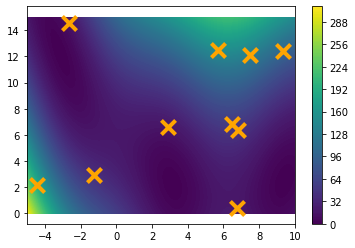

In [11]:
set_random_seed(555)

# Training points
N_train = 10
X_train = torch.rand(N_train, 2)*15 + torch.FloatTensor([const_x1_min, const_x2_min])
y_train = branin_hoo(X_train)

# Initial points
plot_obj(branin_hoo)
plt.scatter(X_train[:,0].detach().numpy(), X_train[:,1].detach().numpy(), 
            marker="x", s=200, c='orange', zorder=2, linewidth=4);

# StructBayesOpt Paramaters

In [12]:
# Optimiser parameters
adam_num_steps = 100
adam_params={"lr": 0.1}

num_samples = 1
num_candidates = 10

sbo_steps = 20

num_tests = 20

# StructBayesOpt

In [13]:
pyro.clear_param_store()

kernel = gp.kernels.Matern52(input_dim=X_train.shape[1], lengthscale=100*torch.ones(X_train.shape[1]))
semi_model = SemiParametricModel(X_train, y_train, ParametricMeanFn(), kernel)

# Set GP priors
semi_model.gp.kernel.lengthscale = pyro.nn.PyroSample(dist.LogNormal(3, 1).expand([2]).to_event())
semi_model.gp.kernel.variance = pyro.nn.PyroSample(dist.LogNormal(5, 2))
semi_model.gp.noise = pyro.nn.PyroSample(dist.LogNormal(0, 1))

# Autoguide
semi_model_guide = autoguide.AutoMultivariateNormal(semi_model.model)

# Optimizer
optimizer = pyro.optim.Adam(adam_params)
loss = Trace_ELBO()
svi = SVI(semi_model.model, semi_model_guide, optimizer, loss)

# do gradient steps
losses = []
for _ in range(adam_num_steps):
    losses.append(svi.step())


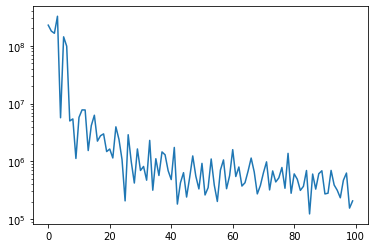

In [14]:
plt.semilogy(losses);

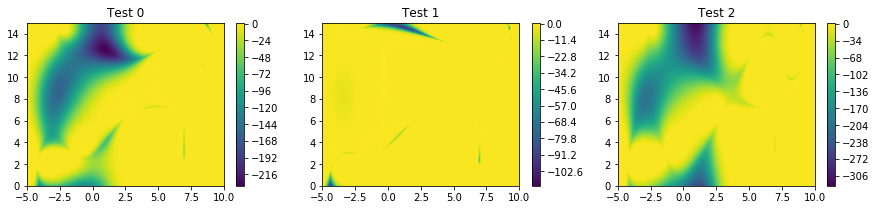

In [15]:
semi_model_predict = pyro.infer.Predictive(semi_model, guide=semi_model_guide, 
                                               num_samples=1, return_sites=('y', 'EI'))

plt.figure(figsize=(15, 3)) 
for i in range(3):
    with torch.no_grad():
        plt.subplot(1,3,i+1)
        plt.title("Test %d" % (i))
        plot_obj(lambda X: semi_model_predict(X)['EI'].mean(0))

# Step 1

In [16]:
x_new = next_x(semi_model_predict, constr, 
    num_candidates=num_candidates, num_steps=adam_num_steps, num_samples=num_samples)
print(x_new)

tensor([[ 0.6795, 14.5149]])


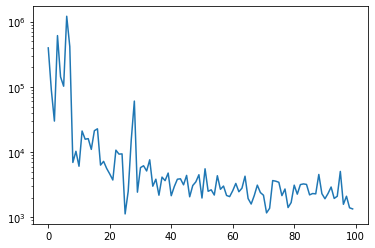

In [17]:
semi_model_guide, losses = update_posterior(semi_model, branin_hoo, 
                                            x_new, num_steps=adam_num_steps, adam_params=adam_params)
plt.semilogy(losses);

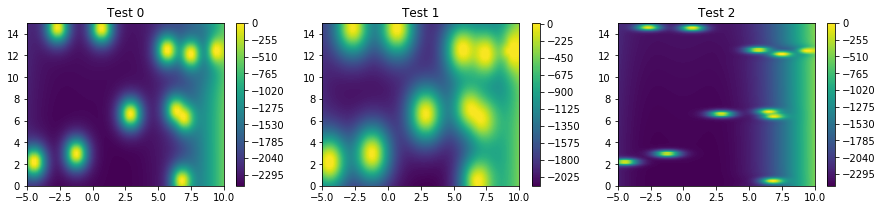

In [18]:
semi_model_predict = pyro.infer.Predictive(semi_model, guide=semi_model_guide, 
                                               num_samples=1, return_sites=('y', 'EI'))

plt.figure(figsize=(15, 3)) 
for i in range(3):
    with torch.no_grad():
        plt.subplot(1,3,i+1)
        plt.title("Test %d" % (i))
        plot_obj(lambda X: semi_model_predict(X)['EI'].mean(0))

# Step 2

In [19]:
x_new = next_x(semi_model_predict, constr, 
    num_candidates=num_candidates, num_steps=adam_num_steps, num_samples=num_samples)
print(x_new)

tensor([[-0.1761,  7.8589]])


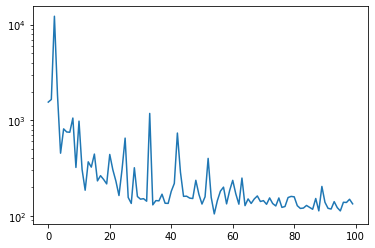

In [20]:
semi_modelsemi_model_guide, losses = update_posterior(semi_model, branin_hoo, 
                                            x_new, num_steps=adam_num_steps, adam_params=adam_params)
plt.semilogy(losses);

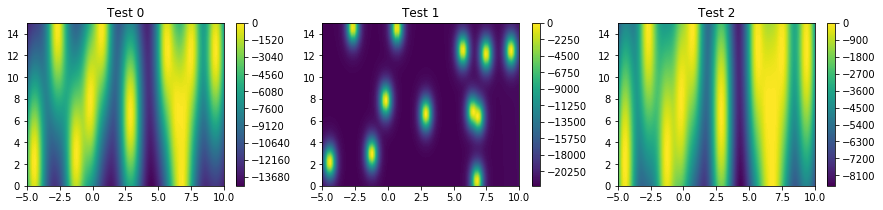

In [21]:
semi_model_predict = pyro.infer.Predictive(semi_model, guide=semi_model_guide, 
                                               num_samples=1, return_sites=('y', 'EI'))

plt.figure(figsize=(15, 3)) 
for i in range(3):
    with torch.no_grad():
        plt.subplot(1,3,i+1)
        plt.title("Test %d" % (i))
        plot_obj(lambda X: semi_model_predict(X)['EI'].mean(0))

# Step 3

In [22]:
x_new = next_x(semi_model_predict, constr, 
    num_candidates=num_candidates, num_steps=adam_num_steps, num_samples=num_samples)
print(x_new)

tensor([[1.5933, 2.0298]])


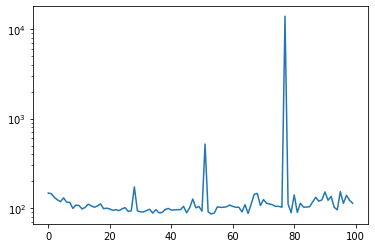

In [23]:
semi_modelsemi_model_guide, losses = update_posterior(semi_model, branin_hoo, 
                                            x_new, num_steps=adam_num_steps, adam_params=adam_params)
plt.semilogy(losses);

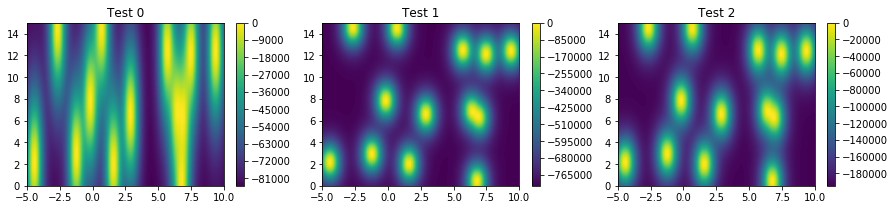

In [24]:
semi_model_predict = pyro.infer.Predictive(semi_model, guide=semi_model_guide, 
                                               num_samples=1, return_sites=('y', 'EI'))

plt.figure(figsize=(15, 3)) 
for i in range(3):
    with torch.no_grad():
        plt.subplot(1,3,i+1)
        plt.title("Test %d" % (i))
        plot_obj(lambda X: semi_model_predict(X)['EI'].mean(0))

# Step 4

In [25]:
x_new = next_x(semi_model_predict, constr, 
    num_candidates=num_candidates, num_steps=adam_num_steps, num_samples=num_samples)
print(x_new)

tensor([[4.4006, 2.9338]])


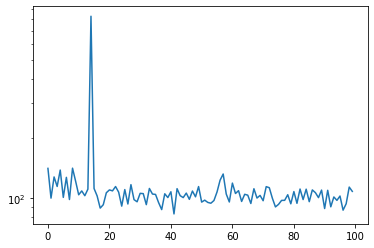

In [26]:
semi_modelsemi_model_guide, losses = update_posterior(semi_model, branin_hoo, 
                                            x_new, num_steps=adam_num_steps, adam_params=adam_params)
plt.semilogy(losses);

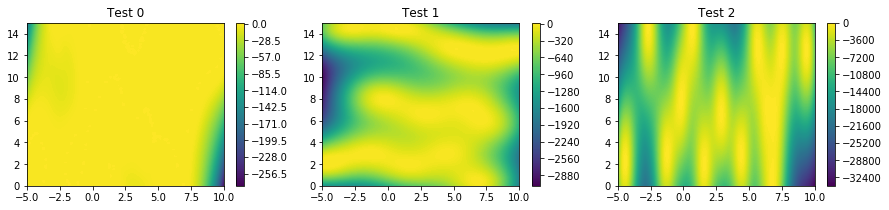

In [27]:
semi_model_predict = pyro.infer.Predictive(semi_model, guide=semi_model_guide, 
                                               num_samples=1, return_sites=('y', 'EI'))

plt.figure(figsize=(15, 3)) 
for i in range(3):
    with torch.no_grad():
        plt.subplot(1,3,i+1)
        plt.title("Test %d" % (i))
        plot_obj(lambda X: semi_model_predict(X)['EI'].mean(0))

tensor([[3.1940, 0.1083]])
tensor([[9.2326, 0.0335]])
tensor([[7.9839e+00, 4.4045e-03]])


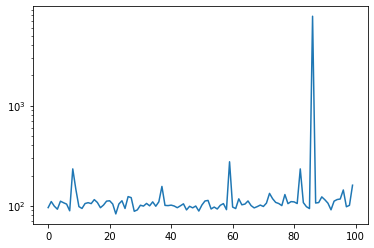

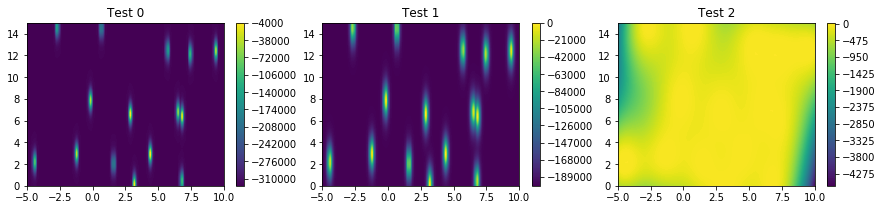

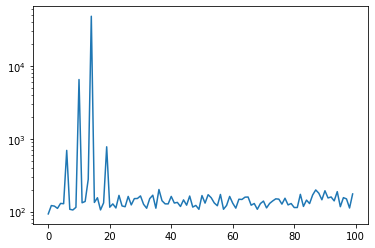

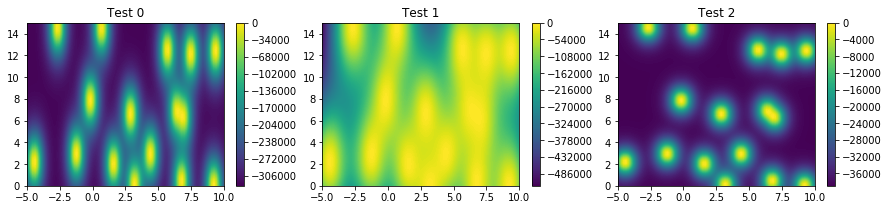

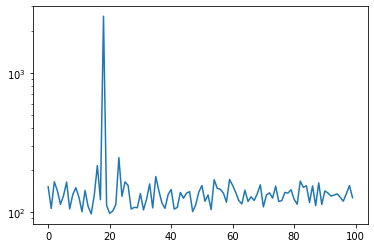

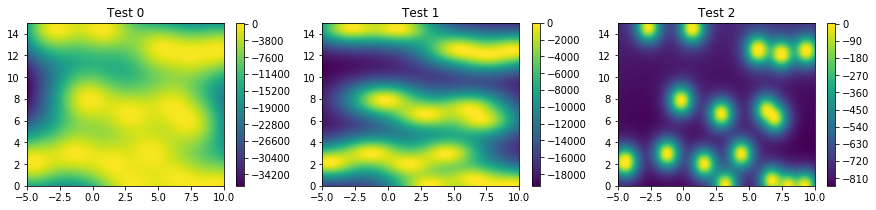

In [28]:
for _ in range(3):
    x_new = next_x(semi_model_predict, constr, 
    num_candidates=num_candidates, num_steps=adam_num_steps, num_samples=num_samples)
    print(x_new)
    
    semi_modelsemi_model_guide, losses = update_posterior(semi_model, branin_hoo, 
                                            x_new, num_steps=adam_num_steps, adam_params=adam_params)
    plt.figure()
    plt.semilogy(losses);
    
    semi_model_predict = pyro.infer.Predictive(semi_model, guide=semi_model_guide, 
                                               num_samples=1, return_sites=('y', 'EI'))

    plt.figure(figsize=(15, 3)) 
    for i in range(3):
        with torch.no_grad():
            plt.subplot(1,3,i+1)
            plt.title("Test %d" % (i))
            plot_obj(lambda X: semi_model_predict(X)['EI'].mean(0))

tensor([[-1.1160, 13.2516]])
tensor([[8.6545, 8.7851]])
tensor([[9.9530, 4.9730]])


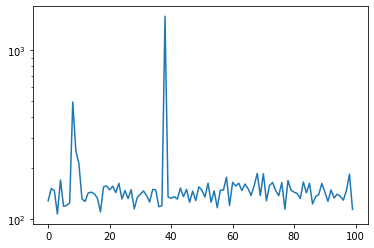

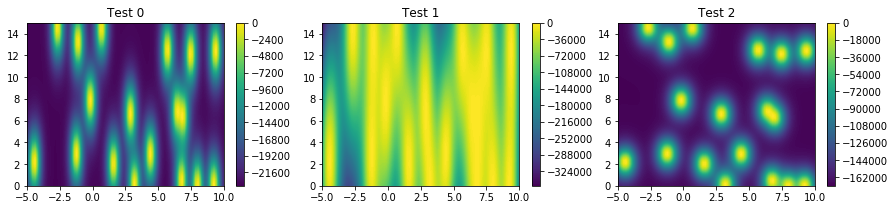

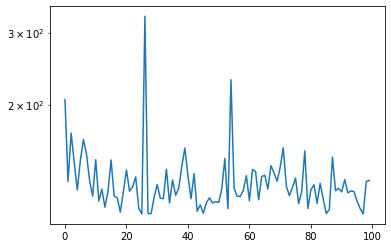

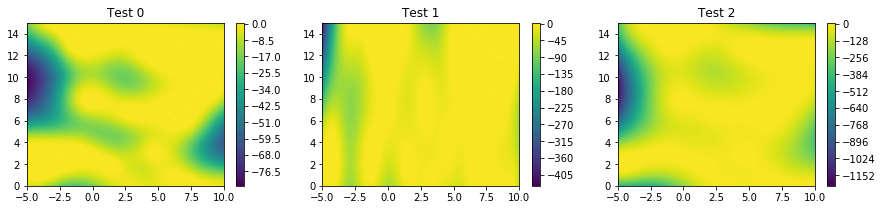

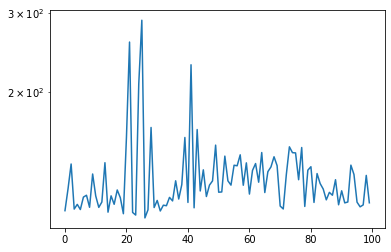

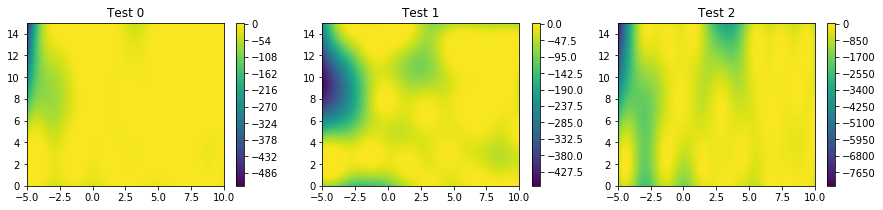

In [29]:
for _ in range(3):
    x_new = next_x(semi_model_predict, constr, 
    num_candidates=num_candidates, num_steps=adam_num_steps, num_samples=num_samples)
    print(x_new)
    
    semi_modelsemi_model_guide, losses = update_posterior(semi_model, branin_hoo, 
                                            x_new, num_steps=adam_num_steps, adam_params=adam_params)
    plt.figure()
    plt.semilogy(losses);
    
    semi_model_predict = pyro.infer.Predictive(semi_model, guide=semi_model_guide, 
                                               num_samples=1, return_sites=('y', 'EI'))

    plt.figure(figsize=(15, 3)) 
    for i in range(3):
        with torch.no_grad():
            plt.subplot(1,3,i+1)
            plt.title("Test %d" % (i))
            plot_obj(lambda X: semi_model_predict(X)['EI'].mean(0))

tensor([[-4.9791, 12.5613]])
tensor([[ 3.9649, 14.9966]])
tensor([[-4.8983,  6.8605]])


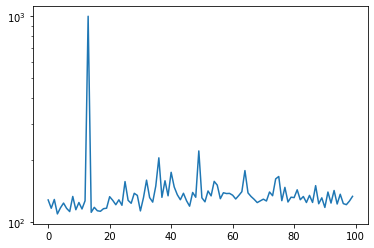

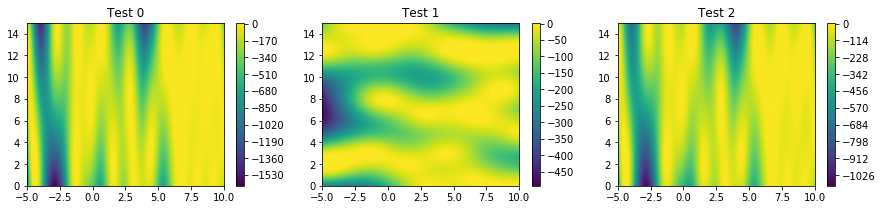

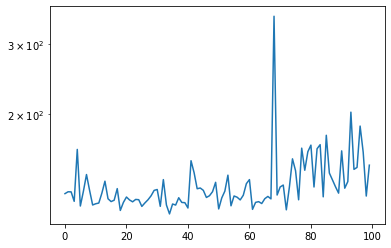

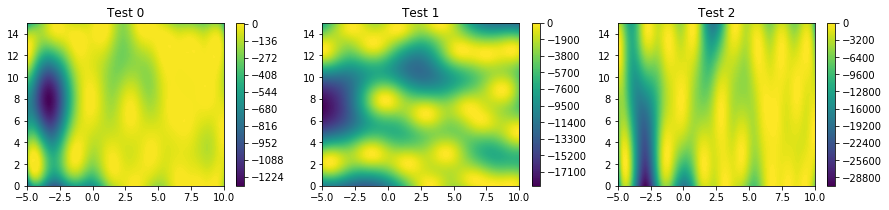

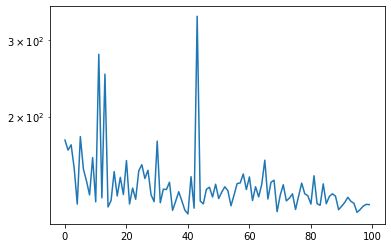

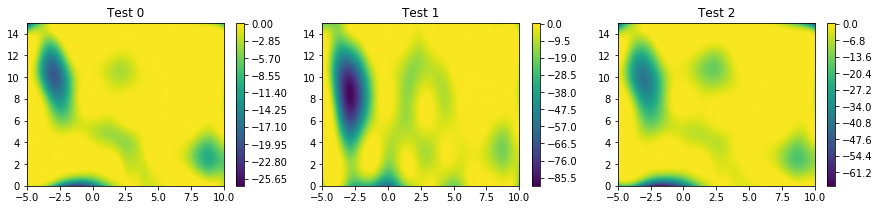

In [30]:
for _ in range(3):
    x_new = next_x(semi_model_predict, constr, 
    num_candidates=num_candidates, num_steps=adam_num_steps, num_samples=num_samples)
    print(x_new)
    
    semi_modelsemi_model_guide, losses = update_posterior(semi_model, branin_hoo, 
                                            x_new, num_steps=adam_num_steps, adam_params=adam_params)
    plt.figure()
    plt.semilogy(losses);
    
    semi_model_predict = pyro.infer.Predictive(semi_model, guide=semi_model_guide, 
                                               num_samples=1, return_sites=('y', 'EI'))

    plt.figure(figsize=(15, 3)) 
    for i in range(3):
        with torch.no_grad():
            plt.subplot(1,3,i+1)
            plt.title("Test %d" % (i))
            plot_obj(lambda X: semi_model_predict(X)['EI'].mean(0))

tensor([[-2.6842,  8.7947]])
tensor([[8.7766, 2.7646]])
tensor([[4.8321, 0.0132]])


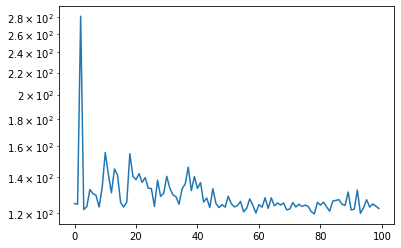

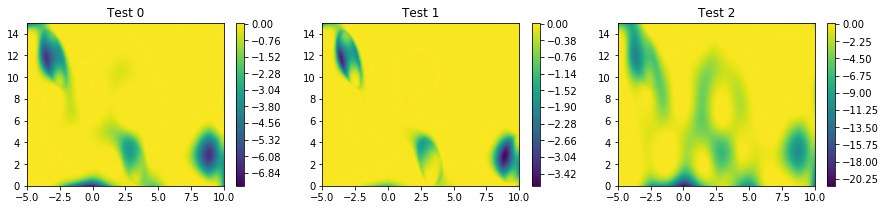

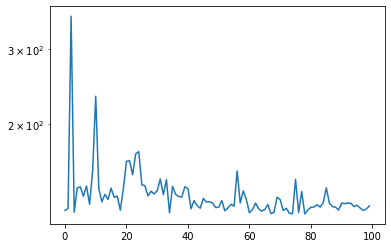

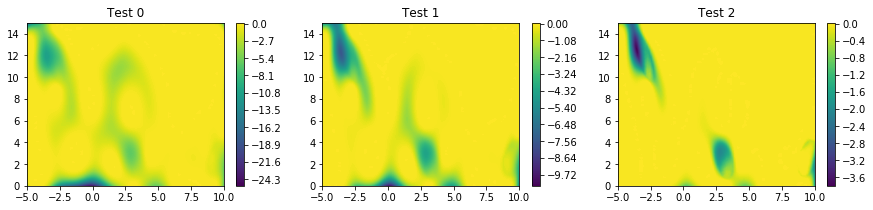

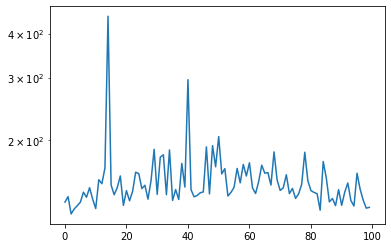

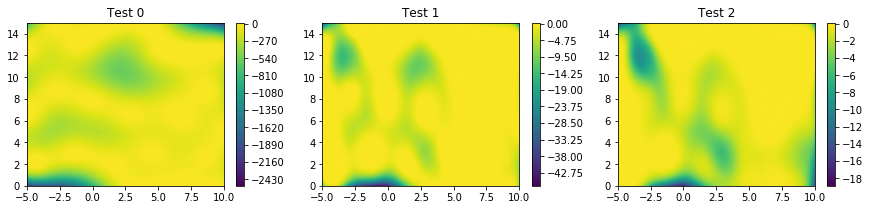

In [31]:
for _ in range(3):
    x_new = next_x(semi_model_predict, constr, 
    num_candidates=num_candidates, num_steps=adam_num_steps, num_samples=num_samples)
    print(x_new)
    
    semi_modelsemi_model_guide, losses = update_posterior(semi_model, branin_hoo, 
                                            x_new, num_steps=adam_num_steps, adam_params=adam_params)
    plt.figure()
    plt.semilogy(losses);
    
    semi_model_predict = pyro.infer.Predictive(semi_model, guide=semi_model_guide, 
                                               num_samples=1, return_sites=('y', 'EI'))

    plt.figure(figsize=(15, 3)) 
    for i in range(3):
        with torch.no_grad():
            plt.subplot(1,3,i+1)
            plt.title("Test %d" % (i))
            plot_obj(lambda X: semi_model_predict(X)['EI'].mean(0))

In [32]:
for _ in range(3):
    x_new = next_x(semi_model_predict, constr, 
    num_candidates=num_candidates, num_steps=adam_num_steps, num_samples=num_samples)
    print(x_new)
    
    semi_modelsemi_model_guide, losses = update_posterior(semi_model, branin_hoo, 
                                            x_new, num_steps=adam_num_steps, adam_params=adam_params)
    plt.figure()
    plt.semilogy(losses);
    
    semi_model_predict = pyro.infer.Predictive(semi_model, guide=semi_model_guide, 
                                               num_samples=1, return_sites=('y', 'EI'))

    plt.figure(figsize=(15, 3)) 
    for i in range(3):
        with torch.no_grad():
            plt.subplot(1,3,i+1)
            plt.title("Test %d" % (i))
            plot_obj(lambda X: semi_model_predict(X)['EI'].mean(0))

tensor([[nan, nan]])


RuntimeError: cholesky_cpu: U(27,27) is zero, singular U.
             Trace Shapes:    
              Param Sites:    
             Sample Sites:    
parametric_mean.alpha dist |  
                     value |  
 parametric_mean.beta dist |  
                     value |  
parametric_mean.gamma dist |  
                     value |  
gp.kernel.lengthscale dist | 2
                     value | 2
   gp.kernel.variance dist |  
                     value |  
             gp.noise dist |  
                     value |  
Trace Shapes:
 Param Sites:
Sample Sites: